<a href="https://colab.research.google.com/github/UEC-MaTa/News_Aggregator/blob/main/news_category_classification_multiclass_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **News Category Classification using LSTM**
**News categories included in this dataset include business; science and technology; entertainment; and health.**

**Different news articles that refer to the same news item (e.g., several articles about recently released employment statistics) are also categorized together.**

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
from tensorflow import keras
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.utils.np_utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing the dataset
dir = pd.read_csv('/content/drive/MyDrive/Tensorflow/NewsAggregator/uci-news-aggregator.csv')
pd.set_option('display.max_rows', None) #コメント参照
#dir = dir[:10]
#dir
dir.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [ ]:
dir.shape #★

(422419, 8)

★  
**set_option()** 関数を使って，オプション値を上書きする．display.max_rows と display.max_columns に None を設定すると「上限なし」となり，DataFrame を省略せずに全て表示できるようになる

**WE HAVE ONLY TWO FEATURES OF USE**

1. **TITLE**
2. **CATEGORY**

In [ ]:
#creating a new dataset with only relevant features.
ds = dir[['TITLE','CATEGORY']]
ds.head()

,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b


In [ ]:
ds.shape #★

(422419, 2)

**HERE YOU CAN SEE THAT ALL CATEGORIES ARE IN ORDER(ALL B's TOGETHER AND SO ON), THEREFORE SHUFFLING THEM FOR OUR CONVENIENCE**

**pandasの行・列をランダムサンプリング（抽出）する .sample()**
pandas.DataFrame, Seriesのsample()メソッドで、行・列または要素をランダムに抽出（ランダムサンプリング）できる。大きいサイズのpandas.DataFrame, Seriesのデータを確認するときに便利。引数nで抽出する行数・列数を指定できる。**引数fracで抽出する行・列の割合を指定できる。1だと100%。**
https://note.nkmk.me/python-pandas-sample/
conti_uselog = conti_uselog.sample(frac=1).reset_index(drop=True)

In [ ]:
#shuffling rows with the help of sample, here (frac = 1) means return all rows
ds = ds.sample(frac=1).reset_index(drop=True)
ds.head()

,TITLE,CATEGORY
0,"Nexus ain't dead, new device to join Android L...",t
1,We don't prey on kids or underpay our workers:...,b
2,California smartphone 'kill switch' bill advances,t
3,Draghi ready to cut rates in June as euro hurt...,b
4,Rapper Andre Johnson's failed penis reattachme...,e



notebooke2c7d39000.ipynbでは  
shuffled = data.**reindex**(np.random.permutation(data.index))で  
以下のとおり

        TITLE	                                             CATEGORY  
259697	Steam Controller to be delayed until 2015	         t  
117718	Sky gazers mesmerized as red hue lights up nig...	 t  
71743	Japan's Antarctic whaling program not scientif...	   t  
140308	Record Store Day 2014 Celebrates Rare Vinyls F...	 e  
169321	Jimmy Fallon and Emma Stone Had an Epic Lip Sy...	 e  
...	...	...  
270325	Jonah Hill apologizes for using gay slur towar...	 e  
583	Europe calls for more US natural gas exports	         b  
215506	MTV Offers Live Stream Of Hangout Music Festival	 e  
49317	Rap Group Wu-Tang Clan Has A Crazy Plan To Mak...	   e  
138422	Lawyer: Director not in Hawaii during alleged ...	 e  
422419 rows × 2 columns

**DATASET IS NOW SHUFFLED**

In [ ]:
#checking for null values
ds.isnull().sum()

TITLE       0
CATEGORY    0
dtype: int64


**NO NULL VALUES FOUND**

<Axes: xlabel='CATEGORY', ylabel='count'>

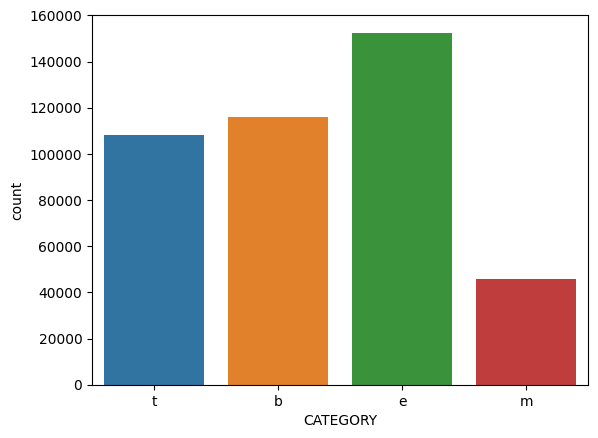

In [ ]:
#plotting graph for categories
sns.countplot(x = 'CATEGORY',data = ds)

**THERE ARE FOUR TYPES OF CATEGORIES-**
1. **b : business (~115000)**
2. **t : science and technology (~110000)**
3. **e : entertainment (~150000)**
4. **m : health (~40000)**


**NOW MOVING ONTO CLEANING AND PREPROCESSING OF THE TEXT DATA**

In [ ]:
#Google Colabでは、nltk、'stopwords'ダウンロードが必要？
import nltk
nltk.download('stopwords')

#以下を実行すると、英語のストップワードを確認できる
#stop_words = stopwords.words('english')
#print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

https://nashidos.hatenablog.com/entry/2020/08/12/205119
ストップワードとは  
自然言語処理においては、出現頻度が高いにも関わらず特別な意味をもたない不要な単語を削除する必要があります。

この不要な語をストップワードと言います。

日本語で言えば、「は」、「です」、「する」などがストップワードに相当します。

英語で言えば「i」, 「a」, 「is」などがストップワードに相当します。

nltkライブラリ  
英語のストップワードはnltkライブラリに用意されています。

以下のPythonコードでストップワードをリストアップできます。

In [ ]:
#cleaning and preprocessing the text

cleaned = []
for i in range(0,len(ds)):

    #removing any other words than (a-z) and (A-Z)
    msg = re.sub('[^a-zA-Z]',' ',ds['TITLE'][i])
                  #[^a-zA-Z] 「^」文字列の文頭,「a-zA-Z」英半角小文字の検索

    #converting all texts to lower case
    msg = msg.lower()

    #tokenizing
    msg = msg.split() #文字列を、単語ごとに分ける
    """ ★確認
    before: gopro shares climb drastically on first day of trading
    after: ['gopro', 'shares', 'climb', 'drastically', 'on', 'first', 'day', 'of', 'trading']
    """

    #stemming and removing stopwords
    ps = PorterStemmer()
    msg = [ps.stem(words) for words in msg if not words in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    cleaned.append(msg)


In [ ]:
len(cleaned) #★

422419

**re.sub** を使用して正規表現で文字列を置換する  
https://uxmilk.jp/8662  
正規表現で文字列を置換する場合は re.sub メソッドを使用します。

置換後の文字列 = re.sub(**正規表現**, 置換する文字列, 置換される文字列 [, 置換回数])  
re.sub メソッドは第１引数に正規表現パターンを指定し、第２引数には置換する文字列を指定し、第３引数には置換される文字列を指定します。第４引数は省略できますが、指定すると指定回数だけ文字列の置換が行われます。

**ステミング**とは、単語から語幹を取り出すことです。  
ステミングにより、例えば、名詞の単数形と複数形や、動詞の原形と活用形を同一として扱えると理解しています。

In [ ]:
#cleaned data with no punctuations,stopwords and all texts in lowercase.
cleaned[:5]

['nexu dead new devic join android l later year',
 'prey kid underpay worker mcdonald ceo',
 'california smartphon kill switch bill advanc',
 'draghi readi cut rate june euro hurt outlook',
 'rapper andr johnson fail peni reattach went wrong']

In [ ]:
#taking dictionary size 5000
dict_size = 5000

#one hot encoding
one_hot_mat = [one_hot(words,dict_size) for words in cleaned]

#now for input as an embedding layer length of all rows should be equal therefore applying padding
#this will make size of all rows equal by adding 0 at starting of the shorter rows
#size of each row will be equal to length of longest row.
embedded_layer = pad_sequences(one_hot_mat,padding = 'pre',maxlen = 150)
#padding: 文字列，'pre'または'post'．各シーケンスの前後どちらを埋めるか．
embedded_layer

array([[   0,    0,    0, ...,  772,  421, 3359],
       [   0,    0,    0, ..., 1872, 1707, 4486],
       [   0,    0,    0, ..., 3362, 3121, 3726],
       ...,
       [   0,    0,    0, ...,  464,  588, 2207],
       [   0,    0,    0, ..., 2326, 1313,  585],
       [   0,    0,    0, ..., 4317, 4528,  760]], dtype=int32)

def one_hot(**input_text**, **n**, **filters**='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', **lower**=True, **split**=' ', **analyzer**=None)   
ワンホット エンコードは、テキストをサイズ n の単語インデックスのリストにエンコードします。

非推奨:   
tf.keras.text.preprocessing.one_hot はテンソルでは動作しないため、新しいコードには推奨されません。 tf.Tensor 入力を受け入れる層を通じて同等の機能を提供する、output_mode='one_hot' を指定した tf.keras.layers.Hashing を優先します。 [前処理レイヤーガイド]を参照してください。
前処理層の概要については、(https://www.tensorflow.org/guide/keras/preprocessing\_layers) を参照してください。

この関数は、入力としてテキスト文字列を受け取り、指定された入力文字列内の単語 (またはトークン) にそれぞれ対応するエンコードされた整数のリストを返します。

引数:  
    input_text: Input text (string).
    n: int. Size of vocabulary.
    filters: list (or concatenation) of characters to filter out, such as
      punctuation. Default: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'!"#$%&()\*+,-./:;&lt;=&gt;?@\[\]^\_`{|}~\t\n, includes basic punctuation, tabs, and newlines.
    lower: boolean. Whether to set the text to lowercase. split: str. Separator for word splitting. analyzer: function. Custom analyzer to split the text
    
**input_text**: 入力テキスト (文字列)。  
**n**: 整数。 語彙のサイズ。  
**フィルター**: フィルターで除外する文字のリスト (または連結)。  
       句読点。 デフォルト: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'!"#$%&()\*+,-./:;&lt;=&gt;?@\[\]^\_`{|} ~\t\n には、基本的な句読点、タブ、改行が含まれます。  
**lower**: ブール値。 テキストを小文字に設定するかどうか。
分割: str.   
**Separator for word splitting. analyzer**:
単語を分割するための区切り文字。
機能。 テキストを分割するためのカスタム アナライザー

**戻り値：** 太字
     \[1, n\] 内の整数のリスト。 各整数は単語をエンコードします (単一性は保証されません)。


In [ ]:
embedded_layer.shape #★

(422419, 150)

In [ ]:
len(one_hot_mat) #★

422419

In [ ]:
print(cleaned[2]) #確認
print(one_hot_mat[2]) #確認
print(embedded_layer[2]) #確認
print(embedded_layer.shape) #確認

california smartphon kill switch bill advanc
[3317, 416, 1406, 3362, 3121, 3726]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 3317  416 1406 3362 3121 3726]
(422419, 150)


In [ ]:
#now creating independent and dependent features
x = embedded_layer
y = np.array(ds['CATEGORY'])

In [ ]:
print(y) #★
print(y.shape) #★

['t' 'b' 't' ... 'm' 't' 'b']
(422419,)


In [ ]:
#converting categorical values of y using OneHotEncoding
le = LabelEncoder()
y = le.fit_transform(y)
print(y) #★
y = to_categorical(y,4)

[3 0 3 ... 2 3 0]


https://docs.google.com/document/d/1uwMfDQYqZUkdtBZo-b7NQG0XwAr3yQ0ydS61Ns1QTM8/edit

＜to_categorical関数の使い方＞  
to_categorical(y, nb_classes=None)  
クラスベクトル（0からnb_classesまでの整数）を categorical_crossentropyとともに用いるためのバイナリのクラス行列に変換します．  
引数  
y: 行列に変換するクラスベクトル  
nb_classes: 総クラス数  
戻り値  
入力のバイナリ行列表現

In [ ]:
y[:10]

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
#splitting the Dataset into Train and Test set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(337935, 150) (337935, 4)
(84484, 150) (84484, 4)


In [ ]:
#creating model using LSTM
model = Sequential()

#taking number features as 50
model.add(Embedding(dict_size,50,input_length = len(x[0])))
model.add(Dropout(0.2))

#adding LSTM layers with 100 neurons
model.add(LSTM(100))

#adding output layer
model.add(Dense(4,activation="softmax"))

#compiling the model
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

#summary of model
model.summary()

#training the model
rnn = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, batch_size = 256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           250000    
                                                                 
 dropout (Dropout)           (None, 150, 50)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 310,804
Trainable params: 310,804
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1321/1321 [==============================] - 1046s 789ms/step - loss: 0.3750 - accuracy: 0.8619 - val_loss: 0.2830 - val_accuracy: 0.9017
Epoch 2/10
1321/1321 [===========

In [ ]:
#evaluating our model
model.evaluate(x_test,y_test)

2641/2641 [==============================] - 116s 44ms/step - loss: 0.2444 - accuracy: 0.9201


[0.2444448173046112, 0.9200795292854309]

In [ ]:
#making predictions
pred = model.predict(x_test)

#saving index of maximum value of pred in preds (because in pred probabilities will come)
preds = []
for i in range(0,len(pred)):
    preds.append(pred[i].argmax())

#saving index of maximum value of y_test in actual
actual = []
for i in range(0,len(y_test)):
    actual.append(y_test[i].argmax())


2641/2641 [==============================] - 123s 46ms/step


In [ ]:
#classification report
from sklearn import metrics
report = metrics.classification_report(actual, preds, target_names = ['b','t','e','m'])
print(report)

              precision    recall  f1-score   support

           b       0.90      0.89      0.90     23246
           t       0.94      0.96      0.95     30561
           e       0.91      0.90      0.90      9092
           m       0.91      0.90      0.90     21585

    accuracy                           0.92     84484
   macro avg       0.92      0.91      0.91     84484
weighted avg       0.92      0.92      0.92     84484



In [ ]:
#checking category of a text
txt = ["An apple a day keeps doctor away."]

#cleaning and preprocessing the text
cleaned = []
for i in range(0,len(txt)):
    msg = re.sub('[^a-zA-Z]',' ',txt[i])
    msg = msg.lower()
    msg = msg.split()
    ps = PorterStemmer()
    msg = [ps.stem(words) for words in msg if not words in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    cleaned.append(msg)

#one hot encoding and embedding layer
one_hot_mat = [one_hot(words,dict_size) for words in cleaned]
embedded_layer = pad_sequences(one_hot_mat,padding = 'pre',maxlen = 150)
embedded_layer

#prediction
pred = model.predict(embedded_layer)
cat = ['Business','Science','Entertainment','Health']
print(pred, cat[np.argmax(pred)])

1/1 [==============================] - 1s 563ms/step
[[0.01290297 0.00933975 0.07193989 0.9058174 ]] Health


In [ ]:
#checking category of a text
txt = ["Fed official says weak data caused by weather, should not slow taper"] #確認

#cleaning and preprocessing the text
cleaned = []
for i in range(0,len(txt)):
    msg = re.sub('[^a-zA-Z]',' ',txt[i])
    msg = msg.lower()
    msg = msg.split()
    ps = PorterStemmer()
    msg = [ps.stem(words) for words in msg if not words in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    cleaned.append(msg)

#one hot encoding and embedding layer
one_hot_mat = [one_hot(words,dict_size) for words in cleaned]
embedded_layer = pad_sequences(one_hot_mat,padding = 'pre',maxlen = 150)
embedded_layer

#prediction
pred = model.predict(embedded_layer)
cat = ['Business','Science','Entertainment','Health']
print(pred, cat[np.argmax(pred)])

1/1 [==============================] - 0s 135ms/step
[[0.7717197  0.00503838 0.08600702 0.13723487]] Business
